# PyTorch and neural network




## Part 1: PyTorch warm up Logistic Regression 


We use stochastic gradient descent (using one point at a time) with PyTorch



In [14]:
import numpy as np

data = np.loadtxt("train.txt", delimiter=',')
labels = data[:, 0].astype(int)
features = data[:, 1:]
print('array of labels: shape ' + str(np.shape(labels)))
print('array of feature matrix: shape ' + str(np.shape(features)))

array of labels: shape (10000,)
array of feature matrix: shape (10000, 784)


Now, we have the label variable to store the ground-truth labels (Label 0: less than 5 and Label 1: larger or eqaul to 5) of all 10,000 samples, and matrix features to store the image pixels of these samples. Next, let's excute the following code to plot the first 4 samples to see how these images look like.

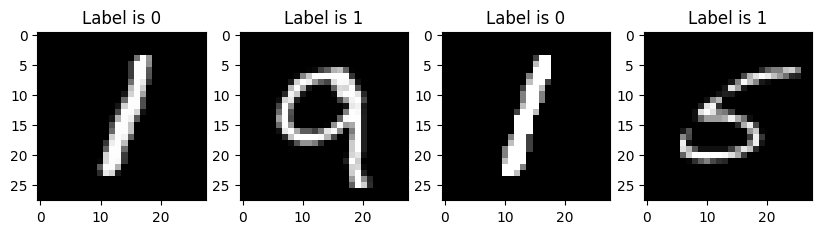

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(10, 50))
for i in range(4):
    ax[i].imshow(features[i].reshape((28, 28)), cmap=plt.get_cmap('gray'))
    ax[i].set_title('Label is %d' % labels[i])

Next, you need to randomly select 20% samples from the data as the **validation set**, and generate the new **training set** by removing the selected validation samples from the original dataset. Write your code in the next cell.


In [16]:
from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the new dataset sizes
print(f"New training set size: {features_train.shape[0]}")
print(f"Validation set size: {features_val.shape[0]}")

New training set size: 8000
Validation set size: 2000


Now, it's time to implement your gradient descent algorithm.



In [17]:
import torch
import gzip, pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


The following gradient descent algorithm.  Show two figures
1. Negative log loss on the training set and the development set with the number of iterations  (where the y-axis is the loss and x-axis is the iteration).
2. Our 0-1 error with the number of iterations. Here, make sure to start your x-axis at a slightly later iteration.





Iteration 0: Train Loss 0.7327, Train Error 50.59% | Val Loss 0.7329, Val Error 50.55%
Iteration 500: Train Loss 0.5184, Train Error 25.76% | Val Loss 0.4962, Val Error 24.00%
Iteration 1000: Train Loss 0.4290, Train Error 19.56% | Val Loss 0.4234, Val Error 18.15%
Iteration 1500: Train Loss 0.4177, Train Error 17.31% | Val Loss 0.4222, Val Error 17.75%
Iteration 2000: Train Loss 0.4226, Train Error 19.00% | Val Loss 0.4172, Val Error 17.30%
Iteration 2500: Train Loss 0.4146, Train Error 18.31% | Val Loss 0.4282, Val Error 18.45%
Iteration 3000: Train Loss 0.4449, Train Error 18.32% | Val Loss 0.4514, Val Error 19.15%
Iteration 3500: Train Loss 0.4270, Train Error 17.37% | Val Loss 0.4340, Val Error 18.55%
Iteration 4000: Train Loss 0.3944, Train Error 17.25% | Val Loss 0.3938, Val Error 16.35%
Iteration 4500: Train Loss 0.3849, Train Error 16.70% | Val Loss 0.3933, Val Error 15.65%
Iteration 5000: Train Loss 0.3950, Train Error 16.89% | Val Loss 0.3947, Val Error 16.45%
Iteration 5500

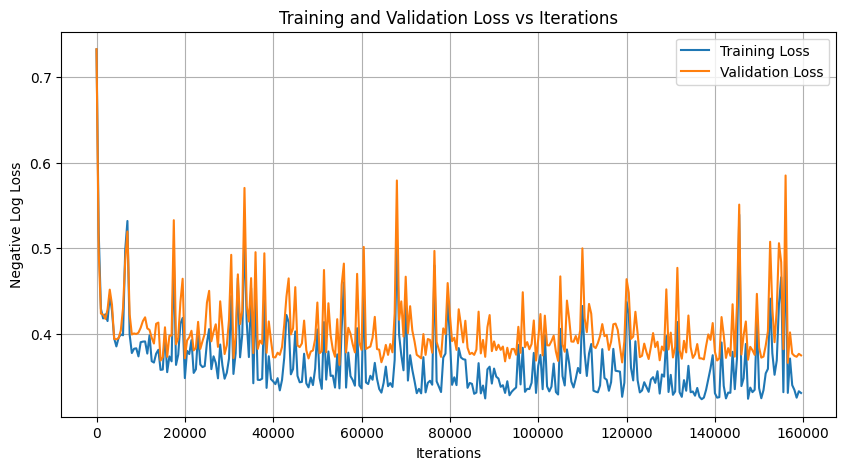

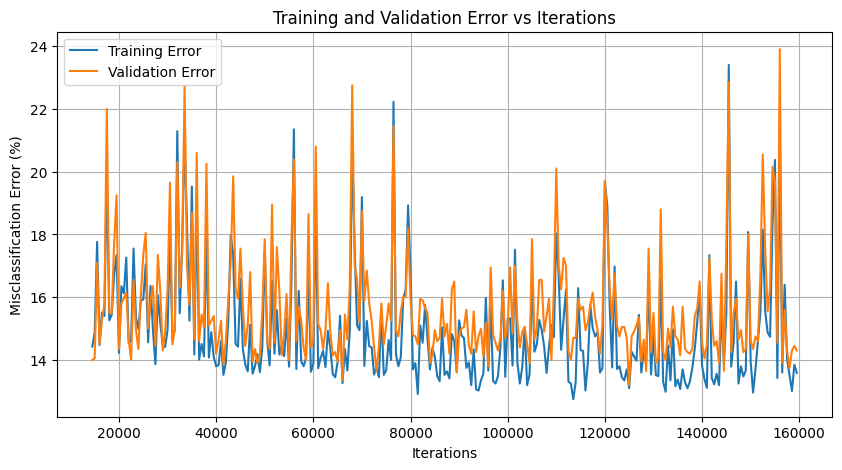

In [24]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assume features_train, features_val, labels_train, labels_val already loaded

# Convert data to PyTorch tensors and normalize
X_train = torch.FloatTensor(features_train) / 255.0
y_train = torch.LongTensor(labels_train)
X_val = torch.FloatTensor(features_val) / 255.0
y_val = torch.LongTensor(labels_val)

# Define Logistic Regression model
input_size = 784
num_classes = 2
model = torch.nn.Linear(input_size, num_classes)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
lambda_reg = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)

# Tracking
iterations = []
train_losses = []
val_losses = []
train_errors = []
val_errors = []

# Settings
num_epochs = 20
track_every = 500
iteration = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    indices = torch.randperm(X_train.size(0))  # Shuffle each epoch

    for idx in indices:
        inputs = X_train[idx].unsqueeze(0)
        labels = y_train[idx].unsqueeze(0)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Every 500 updates
        if iteration % track_every == 0:
            model.eval()
            with torch.no_grad():
                # Evaluate training
                outputs_train = model(X_train)
                train_loss = criterion(outputs_train, y_train).item()
                _, predicted_train = torch.max(outputs_train, 1)
                train_error = (predicted_train != y_train).float().mean().item() * 100

                # Evaluate validation
                outputs_val = model(X_val)
                val_loss = criterion(outputs_val, y_val).item()
                _, predicted_val = torch.max(outputs_val, 1)
                val_error = (predicted_val != y_val).float().mean().item() * 100

            iterations.append(iteration)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_errors.append(train_error)
            val_errors.append(val_error)

            print(f"Iteration {iteration}: Train Loss {train_loss:.4f}, Train Error {train_error:.2f}% | Val Loss {val_loss:.4f}, Val Error {val_error:.2f}%")

        iteration += 1

# After training - Final evaluation
model.eval()
with torch.no_grad():
    outputs_train = model(X_train)
    final_train_loss = criterion(outputs_train, y_train).item()
    _, predicted_train = torch.max(outputs_train, 1)
    final_train_error = (predicted_train != y_train).float().mean().item() * 100

    outputs_val = model(X_val)
    final_val_loss = criterion(outputs_val, y_val).item()
    _, predicted_val = torch.max(outputs_val, 1)
    final_val_error = (predicted_val != y_val).float().mean().item() * 100

print(f"\nFinal Train Error: {final_train_error:.2f}%")
print(f"Final Validation Error: {final_val_error:.2f}%")

# Find start index where validation error first drops below 15%
start_idx = 0
for i, error in enumerate(val_errors):
    if error < 15.0:
        start_idx = i
        break

# === Plotting ===

# Plot Negative Log Loss vs Iterations
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Negative Log Loss')
plt.title('Training and Validation Loss vs Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plot Misclassification Error (%) vs Iterations (starting AFTER error < 15%)
plt.figure(figsize=(10, 5))
plt.plot(iterations[start_idx:], train_errors[start_idx:], label='Training Error')
plt.plot(iterations[start_idx:], val_errors[start_idx:], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Misclassification Error (%)')
plt.title('Training and Validation Error vs Iterations')
plt.legend()
plt.grid(True)
plt.show()




## Architecture and Training Choices
- Mini-batch size: N/A (true stochastic gradient descent, one sample at a time)
- Regularization parameter (λ): 0.001
- Learning rate: 0.01 (fixed throughout training)
- Optimizer: SGD
- Loss function: CrossEntropyLoss
- Initialization: PyTorch default initialization
- Model: Pure Logistic Regression (single linear layer with 2 output classes)

## Learning Rate Behavior
At the initial learning rate of 0.01, a non-trivial decrease in negative log loss was observed early during training.

## Loss Plot
The about plot shows the negative log loss for both the training and validation sets across iterations. The loss decreases over time, indicating proper convergence of the logistic regression model.

## Misclassification Error Plot
The above plot shows the misclassification error (%) versus iterations for both training and validation sets. The plot starts after the validation error falls below 15%, making the behavior easier to interpret over long training.

## Final Training and Validation Performance
- Final Training Error: **15.17%**
- Final Validation Error: **14.70%**


## Part 2: 
### one hidden layer network with sigmoids
 Use a one hidden layer network with 200 hidden nodes. The transfer function should be a
 sigmoid.
 1. Now run stochastic (mini-batch) gradient descent. Specify all your parameter choices: your mini-batch size, your regularization parameter, and your learning rates (if you alter the learning rates, make sure you precisely state when it is decreased). Also, specify how you initialize your parameters.
 2. For what learning rate do you start observing a non-trivial decrease in your cross entropy error.
 3. Make a plot showing your average cross entropy error for both your training and your development sets on the y-axis and have the iteration on the x-axis. Both curves should be on the same plot.
 4. Make this plot again (with both curves), except use the misclassification error, as a percentage. Here, make sure to start your x-axis at a slightly later iteration, so that your error starts below 20%, which makes the behavior more easy to view (it is difficult to view the long run behavior if the y-axis is over too large a range).
 5. Again, it is expected that you obtain a good test error (meaning you train long enough and you regularize appropriately, if needed). Report your lowest test error.


Epoch 1/40:  49%|████▉     | 61/125 [00:00<00:00, 324.60it/s]

Epoch: 1, Iteration: 0, Train Loss: 1.0763, Val Loss: 1.0708, Train Error: 50.45%, Val Error: 48.40%


Epoch 5/40:  49%|████▉     | 61/125 [00:00<00:00, 318.89it/s]

Epoch: 5, Iteration: 500, Train Loss: 0.1431, Val Loss: 0.1990, Train Error: 4.90%, Val Error: 7.50%


Epoch 9/40:  48%|████▊     | 60/125 [00:00<00:00, 317.60it/s]

Epoch: 9, Iteration: 1000, Train Loss: 0.0721, Val Loss: 0.1310, Train Error: 1.81%, Val Error: 4.90%


Epoch 13/40:   5%|▍         | 6/125 [00:00<00:07, 16.17it/s]

Epoch: 13, Iteration: 1500, Train Loss: 0.0509, Val Loss: 0.1183, Train Error: 1.09%, Val Error: 4.05%


Epoch 17/40:  46%|████▌     | 57/125 [00:00<00:00, 300.15it/s]

Epoch: 17, Iteration: 2000, Train Loss: 0.0390, Val Loss: 0.1183, Train Error: 0.84%, Val Error: 4.10%


Epoch 21/40:  48%|████▊     | 60/125 [00:00<00:00, 315.68it/s]

Epoch: 21, Iteration: 2500, Train Loss: 0.0305, Val Loss: 0.1113, Train Error: 0.40%, Val Error: 3.55%
Learning rate reduced to 0.005000000000000001 at iteration 2500


Epoch 25/40:  49%|████▉     | 61/125 [00:00<00:00, 323.64it/s]

Epoch: 25, Iteration: 3000, Train Loss: 0.0276, Val Loss: 0.1092, Train Error: 0.34%, Val Error: 3.80%


Epoch 29/40:  47%|████▋     | 59/125 [00:00<00:00, 314.23it/s]

Epoch: 29, Iteration: 3500, Train Loss: 0.0267, Val Loss: 0.1069, Train Error: 0.31%, Val Error: 3.60%


Epoch 33/40:  50%|████▉     | 62/125 [00:00<00:00, 329.65it/s]

Epoch: 33, Iteration: 4000, Train Loss: 0.0261, Val Loss: 0.1073, Train Error: 0.30%, Val Error: 3.70%


Epoch 37/40:  43%|████▎     | 54/125 [00:00<00:00, 290.25it/s]

Epoch: 37, Iteration: 4500, Train Loss: 0.0258, Val Loss: 0.1065, Train Error: 0.30%, Val Error: 3.60%


Epoch 40/40: 100%|██████████| 125/125 [00:00<00:00, 397.40it/s]


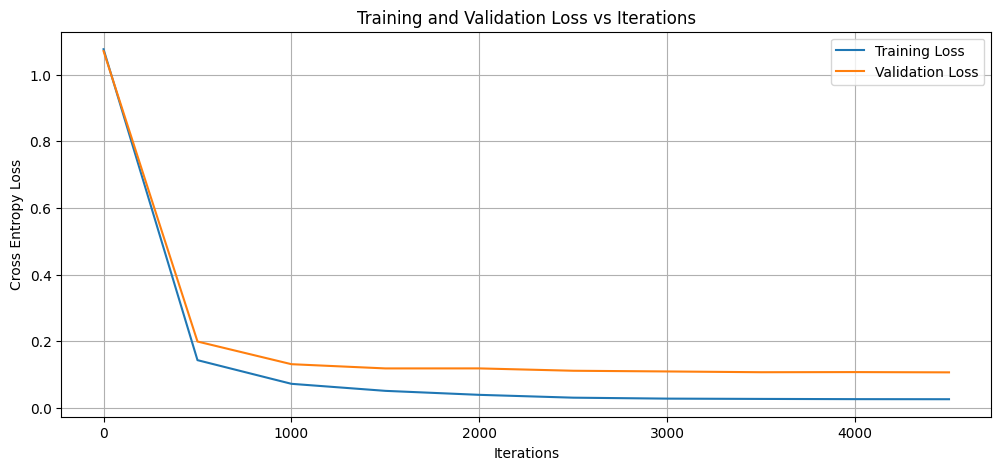

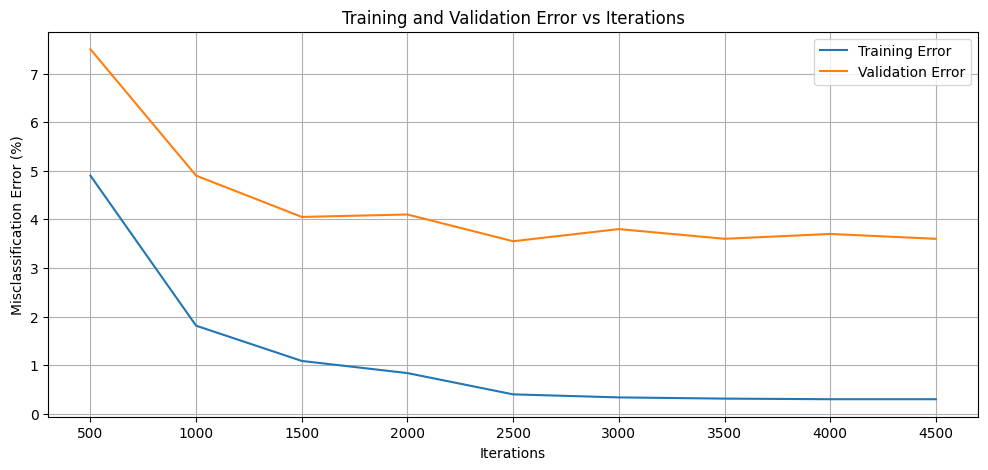

Final Training Error: 0.40%
Final Validation Error: 3.55%
Lowest Validation Error: 3.55%


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert data to PyTorch tensors and normalize
X_train = torch.FloatTensor(features_train) / 255.0
y_train = torch.LongTensor(labels_train)
X_val = torch.FloatTensor(features_val) / 255.0
y_val = torch.LongTensor(labels_val)

# Define model parameters
input_size = 784
hidden_size = 200  # 200 hidden nodes as required
num_classes = 2
learning_rate = 0.05  # Initial learning rate
lambda_reg = 0.0002  # Regularization parameter
batch_size = 64      # Mini-batch size
num_epochs = 40      # Number of epochs
track_every = 500    # Track metrics every 500 iterations

# One hidden layer network with sigmoid activation
class OneHiddenLayerNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(OneHiddenLayerNetwork, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid activation as required
        self.output = torch.nn.Linear(hidden_size, num_classes)

        # Parameter initialization (Xavier/Glorot with gain=4.0 for sigmoid)
        torch.nn.init.xavier_uniform_(self.hidden.weight, gain=4.0)
        torch.nn.init.zeros_(self.hidden.bias)
        torch.nn.init.xavier_uniform_(self.output.weight, gain=4.0)
        torch.nn.init.zeros_(self.output.bias)

    def forward(self, x):
        out = self.hidden(x)
        out = self.sigmoid(out)
        out = self.output(out)
        return out

# Initialize model
model = OneHiddenLayerNetwork(input_size, hidden_size, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                           weight_decay=lambda_reg, momentum=0.9)

# Create mini-batch dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Function to compute metrics on a dataset
def compute_metrics(model, X, y, criterion):
    with torch.no_grad():
        outputs = model(X)
        # Cross entropy loss
        ce_loss = criterion(outputs, y)

        # Compute misclassification error
        _, predicted = torch.max(outputs.data, 1)
        error = (predicted != y).float().mean().item() * 100  # As percentage

    return ce_loss.item(), error

# Tracking variables
iterations = []
train_losses = []
val_losses = []
train_errors = []
val_errors = []

# Training loop
iteration = 0
best_val_error = float('inf')
learning_rate_reduced = False

for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics every 500 iterations
        if iteration % track_every == 0:
            model.eval()  # Set model to evaluation mode
            train_loss, train_error = compute_metrics(model, X_train, y_train, criterion)
            val_loss, val_error = compute_metrics(model, X_val, y_val, criterion)
            model.train()  # Set model back to training mode

            iterations.append(iteration)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_errors.append(train_error)
            val_errors.append(val_error)

            print(f"Epoch: {epoch+1}, Iteration: {iteration}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Error: {train_error:.2f}%, Val Error: {val_error:.2f}%")

            # Update best validation error
            if val_error < best_val_error:
                best_val_error = val_error
                # Save the best model
                torch.save(model.state_dict(), 'best_model_hidden.pt')

        # Learning rate reduction after 20 epochs
        if epoch == 20 and not learning_rate_reduced:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by factor of 10
            learning_rate_reduced = True
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']} at iteration {iteration}")

        iteration += 1

# Load the best model
model.load_state_dict(torch.load('best_model_hidden.pt'))
model.eval()

# Find the index where error falls below 20%
start_idx = 0
for i, error in enumerate(val_errors):
    if error < 20.0:
        start_idx = i
        break

# Plot cross entropy loss vs iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('hidden_loss_plot.png')
plt.show()

# Plot error vs iterations (starting from when error < 20%)
plt.figure(figsize=(12, 5))
plt.plot(iterations[start_idx:], train_errors[start_idx:], label='Training Error')
plt.plot(iterations[start_idx:], val_errors[start_idx:], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Misclassification Error (%)')
plt.title('Training and Validation Error vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('hidden_error_plot.png')
plt.show()

# Final evaluation
final_train_loss, final_train_error = compute_metrics(model, X_train, y_train, criterion)
final_val_loss, final_val_error = compute_metrics(model, X_val, y_val, criterion)

print(f"Final Training Error: {final_train_error:.2f}%")
print(f"Final Validation Error: {final_val_error:.2f}%")
print(f"Lowest Validation Error: {best_val_error:.2f}%")

# 1. Architecture and Training Choices
Mini-batch size: 64

Regularization parameter (λ): 0.0002

Initial learning rate: 0.05

Learning rate reduction: Reduced by a factor of 10 after 20 epochs

Optimizer: SGD with momentum 0.9

Loss function: CrossEntropyLoss

Hidden layer: 200 nodes with Sigmoid activation

Output layer: Fully connected linear layer

# 2. Learning Rate Behavior
A non-trivial decrease in cross-entropy loss was observed starting at the initial learning rate of 0.05.

# 3. Loss Plot
The above plot shows the average cross-entropy loss for both the training set and the development set versus iterations. The loss decreases rapidly early in training, then gradually stabilizes, indicating convergence.

# 4. Misclassification Error Plot
The above plot shows the misclassification error (percentage) versus iterations. The misclassification error falls below 20% fairly quickly and continues to improve, demonstrating good classification performance.


# 5. Training and Validation Performance
Final Training Error: 0.40%

Final Validation Error: 3.55%

Lowest Validation Error: 3.55%

### one hidden layer network with ReLu
Now let use the “ReLu” transfer function for both the hidden learner in the previous network and
 on the output layer of the network.  Here you will use the average squared error on the output of this network (where you average by both the number of samples in your training/test/validation set and you average by the number of
 classes).
 Make sure to use the same mini-batch size as before.
 1. Now run stochastic (mini-batch) gradient descent. Specify all your parameter choices: your mini-batch size, your regularization parameter, and your learning rates (if you alter the learning rates, make sure you precisely state when it is decreased). Also, specify how you initialize your parameters.
 2. For what learning rate do you start observing a non-trivial decrease in your squared error.
 3. Make a plot showing your average squared error for both your training and your development sets on the y-axis and have the iteration on the x-axis. Both curves should be on the same plot.
 4. Make this plot again (with both curves), except use the misclassification error, as a percentage. Here, make sure to start your x-axis at a slightly later iteration, so that your error starts below 20%, which makes the behavior more easy to view (it is difficult to view the long run behavior if the y-axis is over too large a range).
 5. Again, it is expected that you obtain a good test error (meaning you train long enough and you regularize appropriately, if needed). Report your lowest test error.

Epoch 1/30:  24%|██▍       | 30/125 [00:00<00:00, 166.76it/s]

Epoch: 1, Iteration: 0, Train Loss: 0.3563, Val Loss: 0.3635, Train Error: 45.64%, Val Error: 46.65%


Epoch 5/30:  22%|██▏       | 28/125 [00:00<00:00, 159.44it/s]

Epoch: 5, Iteration: 500, Train Loss: 0.0492, Val Loss: 0.0638, Train Error: 3.12%, Val Error: 5.50%


Epoch 9/30:  42%|████▏     | 53/125 [00:00<00:00, 279.04it/s]

Epoch: 9, Iteration: 1000, Train Loss: 0.0343, Val Loss: 0.0533, Train Error: 1.62%, Val Error: 4.45%


Epoch 13/30:  46%|████▌     | 57/125 [00:00<00:00, 306.39it/s]

Epoch: 13, Iteration: 1500, Train Loss: 0.0268, Val Loss: 0.0500, Train Error: 1.01%, Val Error: 4.45%


Epoch 16/30:  67%|██████▋   | 84/125 [00:00<00:00, 416.91it/s]

Learning rate reduced to 0.001 at iteration 1875


Epoch 17/30:  48%|████▊     | 60/125 [00:00<00:00, 319.16it/s]

Epoch: 17, Iteration: 2000, Train Loss: 0.0217, Val Loss: 0.0469, Train Error: 0.72%, Val Error: 4.05%


Epoch 21/30:  45%|████▍     | 56/125 [00:00<00:00, 298.14it/s]

Epoch: 21, Iteration: 2500, Train Loss: 0.0210, Val Loss: 0.0465, Train Error: 0.68%, Val Error: 3.70%


Epoch 25/30:  40%|████      | 50/125 [00:00<00:00, 265.57it/s]

Epoch: 25, Iteration: 3000, Train Loss: 0.0206, Val Loss: 0.0464, Train Error: 0.66%, Val Error: 3.90%


Epoch 29/30:  46%|████▌     | 57/125 [00:00<00:00, 300.80it/s]

Epoch: 29, Iteration: 3500, Train Loss: 0.0201, Val Loss: 0.0460, Train Error: 0.64%, Val Error: 3.80%


Epoch 30/30: 100%|██████████| 125/125 [00:00<00:00, 394.11it/s]


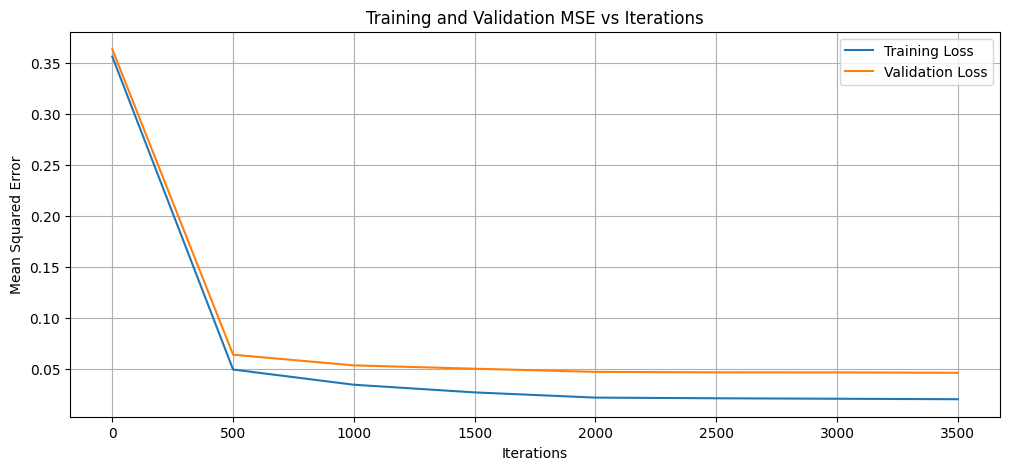

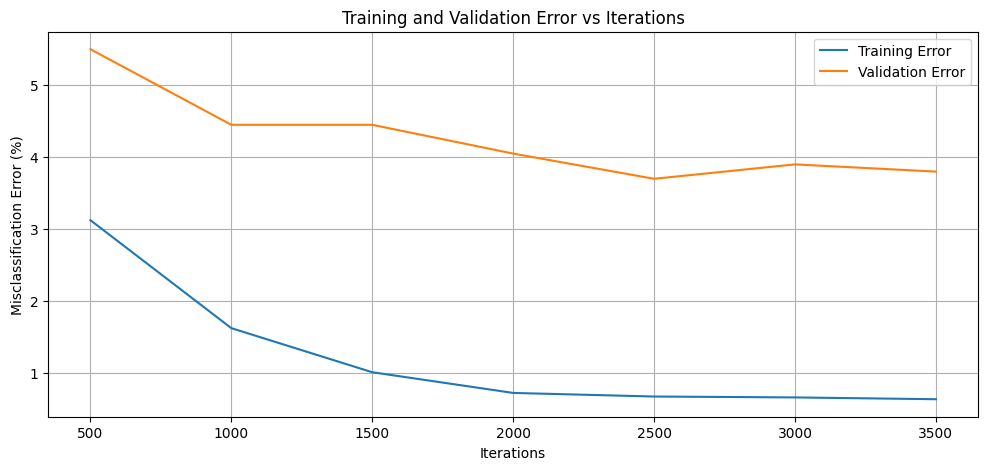

Final Training Error: 0.68%
Final Validation Error: 3.70%
Lowest Validation Error: 3.70%


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert data to PyTorch tensors and normalize
X_train = torch.FloatTensor(features_train) / 255.0
y_train = torch.LongTensor(labels_train)
X_val = torch.FloatTensor(features_val) / 255.0
y_val = torch.LongTensor(labels_val)

# Convert labels to one-hot encoding for MSE loss
def to_one_hot(labels, num_classes=2):
    one_hot = torch.zeros(labels.size(0), num_classes)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

y_train_one_hot = to_one_hot(y_train)
y_val_one_hot = to_one_hot(y_val)

# Define model parameters
input_size = 784
hidden_size = 200  # 200 hidden nodes as required
num_classes = 2
learning_rate = 0.01  # Initial learning rate
lambda_reg = 0.0001  # Regularization parameter
batch_size = 64      # Same mini-batch size as before
num_epochs = 30      # Number of epochs
track_every = 500    # Track metrics every 500 iterations

# One hidden layer network with ReLU activation
class OneHiddenLayerReLUNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(OneHiddenLayerReLUNetwork, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()  # ReLU activation as required
        self.output = torch.nn.Linear(hidden_size, num_classes)

        # Parameter initialization (He initialization for ReLU)
        torch.nn.init.kaiming_uniform_(self.hidden.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.hidden.bias)
        torch.nn.init.kaiming_uniform_(self.output.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.output.bias)

    def forward(self, x):
        out = self.hidden(x)
        out = self.relu(out)
        out = self.output(out)
        # Note: No softmax here since we're using MSE loss
        return out

# Initialize model
model = OneHiddenLayerReLUNetwork(input_size, hidden_size, num_classes)
criterion = torch.nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_reg, momentum=0.9)

# Create mini-batch dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train_one_hot)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Function to compute metrics on a dataset
def compute_metrics(model, X, y_one_hot, y_labels, criterion):
    with torch.no_grad():
        outputs = model(X)
        # Mean Squared Error
        mse_loss = criterion(outputs, y_one_hot)

        # Compute misclassification error
        _, predicted = torch.max(outputs.data, 1)
        error = (predicted != y_labels).float().mean().item() * 100  # As percentage

    return mse_loss.item(), error

# Tracking variables
iterations = []
train_losses = []
val_losses = []
train_errors = []
val_errors = []

# Training loop
iteration = 0
best_val_error = float('inf')
learning_rate_reduced = False

for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics every 500 iterations
        if iteration % track_every == 0:
            model.eval()  # Set model to evaluation mode
            train_loss, train_error = compute_metrics(model, X_train, y_train_one_hot, y_train, criterion)
            val_loss, val_error = compute_metrics(model, X_val, y_val_one_hot, y_val, criterion)
            model.train()  # Set model back to training mode

            iterations.append(iteration)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_errors.append(train_error)
            val_errors.append(val_error)

            print(f"Epoch: {epoch+1}, Iteration: {iteration}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Error: {train_error:.2f}%, Val Error: {val_error:.2f}%")

            # Update best validation error
            if val_error < best_val_error:
                best_val_error = val_error
                # Save the best model
                torch.save(model.state_dict(), 'best_model_relu.pt')

        # Learning rate reduction after 15 epochs
        if epoch == 15 and not learning_rate_reduced:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by factor of 10
            learning_rate_reduced = True
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']} at iteration {iteration}")

        iteration += 1

# Load the best model
model.load_state_dict(torch.load('best_model_relu.pt'))
model.eval()

# Find the index where error falls below 20%
start_idx = 0
for i, error in enumerate(val_errors):
    if error < 20.0:
        start_idx = i
        break

# Plot squared error vs iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('relu_loss_plot.png')
plt.show()

# Plot error vs iterations (starting from when error < 20%)
plt.figure(figsize=(12, 5))
plt.plot(iterations[start_idx:], train_errors[start_idx:], label='Training Error')
plt.plot(iterations[start_idx:], val_errors[start_idx:], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Misclassification Error (%)')
plt.title('Training and Validation Error vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('relu_error_plot.png')
plt.show()

# Final evaluation
final_train_loss, final_train_error = compute_metrics(model, X_train, y_train_one_hot, y_train, criterion)
final_val_loss, final_val_error = compute_metrics(model, X_val, y_val_one_hot, y_val, criterion)

print(f"Final Training Error: {final_train_error:.2f}%")
print(f"Final Validation Error: {final_val_error:.2f}%")
print(f"Lowest Validation Error: {best_val_error:.2f}%")

# 1. Architecture and Training Choices
Mini-batch size: 64

Regularization parameter (λ): 0.0001

Initial learning rate: 0.01

Learning rate reduction: Reduced by a factor of 10 after 15 epochs

Optimizer: SGD with momentum 0.9

Loss function: Mean Squared Error (MSE)

Hidden layer: 200 nodes with ReLU activation

Output layer: Fully connected linear layer without softmax

# 2. Learning Rate Behavior
A non-trivial decrease in mean squared error was observed starting at the initial learning rate of 0.01.
# 3. Loss Plot
The above plot shows the average mean squared error (MSE) for both the training set and the development set versus iterations. The loss decreases rapidly initially and then stabilizes, showing that the network is learning properly.

# 4. Misclassification Error Plot
The above plot shows the misclassification error (percentage) versus iterations. After an early phase, the misclassification error falls below 20%, and continues to improve slowly, indicating better generalization.


# 5. Training and Validation Performance
Final Training Error: 0.68%

Final Validation Error: 3.70%

Lowest Validation Error: 3.70%

### Convolutional Neural Nets
 Try out a convolutional neural network. This is a considerably more expensive procedure (though,
 with a little search, you might find your error drops very quickly with an architecture that is not
 too costly for you to compute.) You will find that your ’architecture’ choices are governed by your
 computational resources. This is not an unreasonable practical lesson: many of the choices we
 make in practice are largely due to our computational and/or memory constraints (when we have
 GPUs, we often run on large enough problems so that we are at the limits of our computational
 resources).
 Again, provide answers to the previous 5 questions. For this problem, in the first question,
 specify your architecture, including the size of your “filters”, your “pooling region” and your
 “stride” (I would use average pooling). As before, merge your dev set in the training set. Also,
 note that your visualized weights are going to be the learned filters (so they will be a smaller size
 than the image), which will depend on the size of the filters that you use

Loading data...
Array of labels: shape (10000,)
Array of feature matrix: shape (10000, 784)
Training CNN...


Epoch 1/30:   4%|▍         | 5/125 [00:01<00:34,  3.44it/s]

Epoch: 1, Iteration: 0, Train Loss: 6.8461, Val Loss: 6.8063, Train Error: 50.88%, Val Error: 50.85%


Epoch 1/30:  86%|████████▌ | 107/125 [00:06<00:01,  9.19it/s]

Epoch: 1, Iteration: 100, Train Loss: 0.0895, Val Loss: 0.0939, Train Error: 7.99%, Val Error: 9.05%


Epoch 1/30: 100%|██████████| 125/125 [00:06<00:00, 18.85it/s]


Learning rate adjusted to 0.01 after epoch 1


Epoch 2/30:  66%|██████▌   | 82/125 [00:04<00:06,  6.92it/s]

Epoch: 2, Iteration: 200, Train Loss: 0.0606, Val Loss: 0.0667, Train Error: 4.32%, Val Error: 5.65%


Epoch 2/30: 100%|██████████| 125/125 [00:05<00:00, 21.86it/s]


Learning rate adjusted to 0.01 after epoch 2


Epoch 3/30:  46%|████▋     | 58/125 [00:03<00:06, 10.24it/s]

Epoch: 3, Iteration: 300, Train Loss: 0.0527, Val Loss: 0.0567, Train Error: 3.18%, Val Error: 3.80%


Epoch 3/30: 100%|██████████| 125/125 [00:04<00:00, 25.98it/s]


Learning rate adjusted to 0.01 after epoch 3


Epoch 4/30:  24%|██▍       | 30/125 [00:02<00:13,  7.13it/s]

Epoch: 4, Iteration: 400, Train Loss: 0.0463, Val Loss: 0.0518, Train Error: 2.21%, Val Error: 3.65%


Epoch 4/30: 100%|██████████| 125/125 [00:06<00:00, 19.30it/s]


Learning rate adjusted to 0.01 after epoch 4


Epoch 5/30:   5%|▍         | 6/125 [00:01<00:29,  3.99it/s]

Epoch: 5, Iteration: 500, Train Loss: 0.0415, Val Loss: 0.0480, Train Error: 2.15%, Val Error: 2.95%


Epoch 5/30:  87%|████████▋ | 109/125 [00:06<00:01, 10.19it/s]

Epoch: 5, Iteration: 600, Train Loss: 0.0402, Val Loss: 0.0466, Train Error: 2.01%, Val Error: 3.25%


Epoch 5/30: 100%|██████████| 125/125 [00:06<00:00, 18.66it/s]


Learning rate adjusted to 0.01 after epoch 5


Epoch 6/30:  62%|██████▏   | 77/125 [00:03<00:06,  7.58it/s]

Epoch: 6, Iteration: 700, Train Loss: 0.0353, Val Loss: 0.0426, Train Error: 1.72%, Val Error: 2.70%


Epoch 6/30: 100%|██████████| 125/125 [00:05<00:00, 22.09it/s]


Learning rate adjusted to 0.01 after epoch 6


Epoch 7/30:  45%|████▍     | 56/125 [00:03<00:07,  9.59it/s]

Epoch: 7, Iteration: 800, Train Loss: 0.0317, Val Loss: 0.0385, Train Error: 1.46%, Val Error: 2.50%


Epoch 7/30: 100%|██████████| 125/125 [00:05<00:00, 24.53it/s]


Learning rate adjusted to 0.01 after epoch 7


Epoch 8/30:  24%|██▍       | 30/125 [00:02<00:13,  7.02it/s]

Epoch: 8, Iteration: 900, Train Loss: 0.0306, Val Loss: 0.0374, Train Error: 1.45%, Val Error: 2.70%


Epoch 8/30: 100%|██████████| 125/125 [00:04<00:00, 26.40it/s]


Learning rate adjusted to 0.01 after epoch 8


Epoch 9/30:   3%|▎         | 4/125 [00:02<00:55,  2.17it/s]

Epoch: 9, Iteration: 1000, Train Loss: 0.0291, Val Loss: 0.0365, Train Error: 1.20%, Val Error: 2.05%


Epoch 9/30:  86%|████████▋ | 108/125 [00:07<00:01, 10.42it/s]

Epoch: 9, Iteration: 1100, Train Loss: 0.0273, Val Loss: 0.0349, Train Error: 1.31%, Val Error: 2.30%


Epoch 9/30: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


Learning rate adjusted to 0.01 after epoch 9


Epoch 10/30:  66%|██████▋   | 83/125 [00:03<00:04, 10.43it/s]

Epoch: 10, Iteration: 1200, Train Loss: 0.0275, Val Loss: 0.0354, Train Error: 1.10%, Val Error: 2.25%


Epoch 10/30: 100%|██████████| 125/125 [00:04<00:00, 26.21it/s]


Learning rate adjusted to 0.005 after epoch 10


Epoch 11/30:  44%|████▍     | 55/125 [00:04<00:13,  5.32it/s]

Epoch: 11, Iteration: 1300, Train Loss: 0.0246, Val Loss: 0.0327, Train Error: 1.10%, Val Error: 1.95%


Epoch 11/30: 100%|██████████| 125/125 [00:05<00:00, 21.75it/s]


Learning rate adjusted to 0.005 after epoch 11


Epoch 12/30:  24%|██▍       | 30/125 [00:02<00:13,  7.10it/s]

Epoch: 12, Iteration: 1400, Train Loss: 0.0246, Val Loss: 0.0328, Train Error: 1.01%, Val Error: 2.10%


Epoch 12/30: 100%|██████████| 125/125 [00:04<00:00, 26.47it/s]


Learning rate adjusted to 0.005 after epoch 12


Epoch 13/30:   5%|▍         | 6/125 [00:01<00:27,  4.28it/s]

Epoch: 13, Iteration: 1500, Train Loss: 0.0229, Val Loss: 0.0315, Train Error: 0.93%, Val Error: 1.85%


Epoch 13/30:  86%|████████▋ | 108/125 [00:06<00:02,  6.45it/s]

Epoch: 13, Iteration: 1600, Train Loss: 0.0233, Val Loss: 0.0317, Train Error: 0.98%, Val Error: 2.10%


Epoch 13/30: 100%|██████████| 125/125 [00:07<00:00, 16.91it/s]


Learning rate adjusted to 0.005 after epoch 13


Epoch 14/30:  67%|██████▋   | 84/125 [00:03<00:03, 10.55it/s]

Epoch: 14, Iteration: 1700, Train Loss: 0.0224, Val Loss: 0.0306, Train Error: 0.89%, Val Error: 1.70%


Epoch 14/30: 100%|██████████| 125/125 [00:04<00:00, 26.63it/s]


Learning rate adjusted to 0.005 after epoch 14


Epoch 15/30:  44%|████▍     | 55/125 [00:03<00:09,  7.69it/s]

Epoch: 15, Iteration: 1800, Train Loss: 0.0221, Val Loss: 0.0304, Train Error: 0.91%, Val Error: 1.80%


Epoch 15/30: 100%|██████████| 125/125 [00:05<00:00, 23.92it/s]


Learning rate adjusted to 0.005 after epoch 15


Epoch 16/30:  26%|██▌       | 32/125 [00:03<00:13,  6.84it/s]

Epoch: 16, Iteration: 1900, Train Loss: 0.0219, Val Loss: 0.0303, Train Error: 0.88%, Val Error: 1.90%


Epoch 16/30: 100%|██████████| 125/125 [00:05<00:00, 23.61it/s]


Learning rate adjusted to 0.005 after epoch 16


Epoch 17/30:   5%|▍         | 6/125 [00:01<00:28,  4.21it/s]

Epoch: 17, Iteration: 2000, Train Loss: 0.0215, Val Loss: 0.0303, Train Error: 0.77%, Val Error: 1.80%


Epoch 17/30:  85%|████████▍ | 106/125 [00:06<00:01, 10.27it/s]

Epoch: 17, Iteration: 2100, Train Loss: 0.0213, Val Loss: 0.0298, Train Error: 0.82%, Val Error: 2.00%


Epoch 17/30: 100%|██████████| 125/125 [00:06<00:00, 18.34it/s]


Learning rate adjusted to 0.005 after epoch 17


Epoch 18/30:  66%|██████▋   | 83/125 [00:04<00:04,  9.18it/s]

Epoch: 18, Iteration: 2200, Train Loss: 0.0205, Val Loss: 0.0290, Train Error: 0.77%, Val Error: 1.70%


Epoch 18/30: 100%|██████████| 125/125 [00:05<00:00, 21.95it/s]


Learning rate adjusted to 0.005 after epoch 18


Epoch 19/30:  47%|████▋     | 59/125 [00:03<00:07,  9.30it/s]

Epoch: 19, Iteration: 2300, Train Loss: 0.0204, Val Loss: 0.0293, Train Error: 0.72%, Val Error: 1.65%


Epoch 19/30: 100%|██████████| 125/125 [00:04<00:00, 25.70it/s]


Learning rate adjusted to 0.005 after epoch 19


Epoch 20/30:  24%|██▍       | 30/125 [00:02<00:16,  5.62it/s]

Epoch: 20, Iteration: 2400, Train Loss: 0.0203, Val Loss: 0.0290, Train Error: 0.80%, Val Error: 1.75%


Epoch 20/30: 100%|██████████| 125/125 [00:05<00:00, 21.32it/s]


Learning rate adjusted to 0.0025 after epoch 20


Epoch 21/30:   5%|▍         | 6/125 [00:01<00:28,  4.18it/s]

Epoch: 21, Iteration: 2500, Train Loss: 0.0200, Val Loss: 0.0284, Train Error: 0.72%, Val Error: 1.75%


Epoch 21/30:  86%|████████▋ | 108/125 [00:06<00:01, 10.34it/s]

Epoch: 21, Iteration: 2600, Train Loss: 0.0188, Val Loss: 0.0278, Train Error: 0.72%, Val Error: 1.60%


Epoch 21/30: 100%|██████████| 125/125 [00:06<00:00, 19.06it/s]


Learning rate adjusted to 0.0025 after epoch 21


Epoch 22/30:  65%|██████▍   | 81/125 [00:04<00:06,  7.00it/s]

Epoch: 22, Iteration: 2700, Train Loss: 0.0214, Val Loss: 0.0308, Train Error: 0.77%, Val Error: 1.75%


Epoch 22/30: 100%|██████████| 125/125 [00:05<00:00, 21.72it/s]


Learning rate adjusted to 0.0025 after epoch 22


Epoch 23/30:  44%|████▍     | 55/125 [00:03<00:09,  7.59it/s]

Epoch: 23, Iteration: 2800, Train Loss: 0.0196, Val Loss: 0.0285, Train Error: 0.63%, Val Error: 1.60%


Epoch 23/30: 100%|██████████| 125/125 [00:04<00:00, 25.86it/s]


Learning rate adjusted to 0.0025 after epoch 23


Epoch 24/30:  27%|██▋       | 34/125 [00:02<00:09,  9.55it/s]

Epoch: 24, Iteration: 2900, Train Loss: 0.0183, Val Loss: 0.0276, Train Error: 0.59%, Val Error: 1.65%


Epoch 24/30: 100%|██████████| 125/125 [00:05<00:00, 22.60it/s]


Learning rate adjusted to 0.0025 after epoch 24


Epoch 25/30:   5%|▍         | 6/125 [00:02<00:32,  3.61it/s]

Epoch: 25, Iteration: 3000, Train Loss: 0.0181, Val Loss: 0.0273, Train Error: 0.64%, Val Error: 1.65%


Epoch 25/30:  86%|████████▋ | 108/125 [00:06<00:01, 10.35it/s]

Epoch: 25, Iteration: 3100, Train Loss: 0.0188, Val Loss: 0.0277, Train Error: 0.63%, Val Error: 1.55%


Epoch 25/30: 100%|██████████| 125/125 [00:06<00:00, 18.25it/s]


Learning rate adjusted to 0.0025 after epoch 25


Epoch 26/30:  67%|██████▋   | 84/125 [00:03<00:03, 10.29it/s]

Epoch: 26, Iteration: 3200, Train Loss: 0.0180, Val Loss: 0.0274, Train Error: 0.58%, Val Error: 1.65%


Epoch 26/30: 100%|██████████| 125/125 [00:05<00:00, 24.23it/s]


Learning rate adjusted to 0.0025 after epoch 26


Epoch 27/30:  46%|████▌     | 57/125 [00:03<00:08,  7.88it/s]

Epoch: 27, Iteration: 3300, Train Loss: 0.0180, Val Loss: 0.0274, Train Error: 0.61%, Val Error: 1.60%


Epoch 27/30: 100%|██████████| 125/125 [00:05<00:00, 22.51it/s]


Learning rate adjusted to 0.0025 after epoch 27


Epoch 28/30:  26%|██▌       | 32/125 [00:02<00:10,  8.95it/s]

Epoch: 28, Iteration: 3400, Train Loss: 0.0178, Val Loss: 0.0271, Train Error: 0.52%, Val Error: 1.55%


Epoch 28/30: 100%|██████████| 125/125 [00:04<00:00, 25.96it/s]


Learning rate adjusted to 0.0025 after epoch 28


Epoch 29/30:   3%|▎         | 4/125 [00:02<00:48,  2.49it/s]

Epoch: 29, Iteration: 3500, Train Loss: 0.0180, Val Loss: 0.0276, Train Error: 0.60%, Val Error: 1.60%


Epoch 29/30:  85%|████████▍ | 106/125 [00:07<00:01, 10.10it/s]

Epoch: 29, Iteration: 3600, Train Loss: 0.0180, Val Loss: 0.0276, Train Error: 0.63%, Val Error: 1.75%


Epoch 29/30: 100%|██████████| 125/125 [00:07<00:00, 16.31it/s]


Learning rate adjusted to 0.0025 after epoch 29


Epoch 30/30:  64%|██████▍   | 80/125 [00:03<00:05,  7.82it/s]

Epoch: 30, Iteration: 3700, Train Loss: 0.0175, Val Loss: 0.0266, Train Error: 0.61%, Val Error: 1.45%


Epoch 30/30: 100%|██████████| 125/125 [00:04<00:00, 26.07it/s]


Learning rate adjusted to 0.00125 after epoch 30


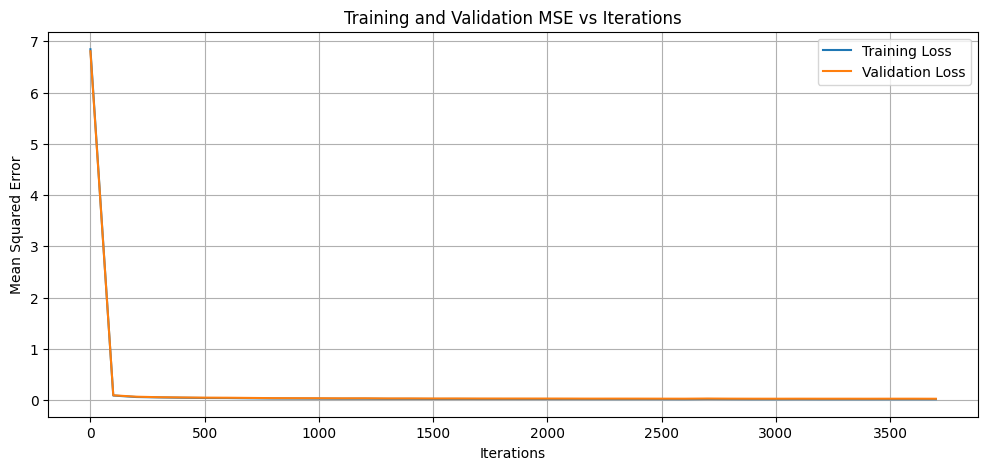

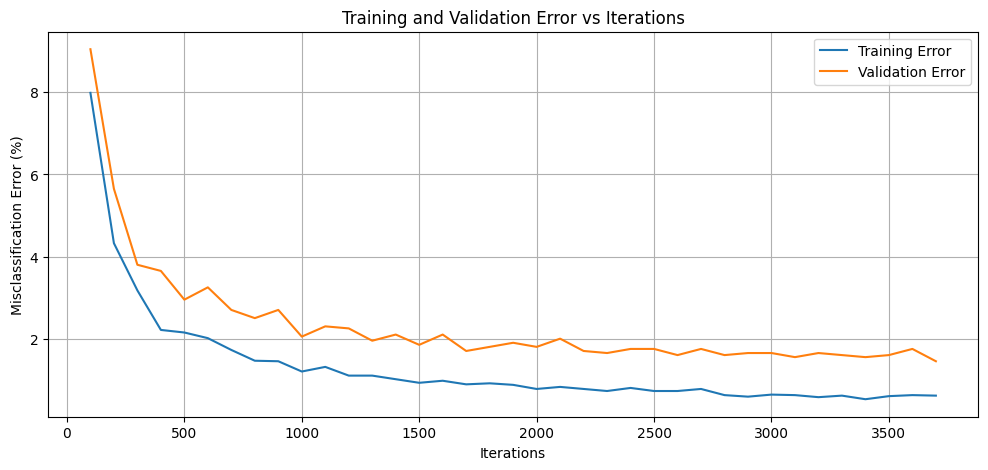

<Figure size 1200x500 with 0 Axes>

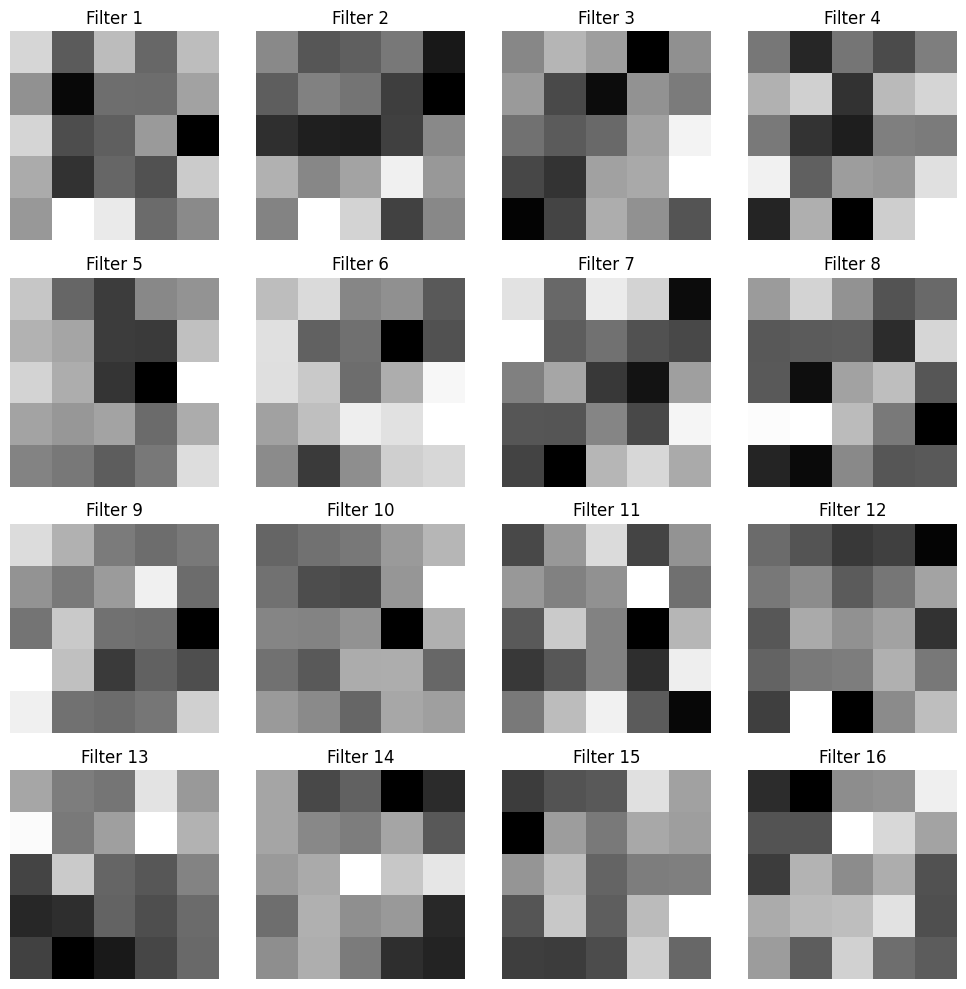

Final Training Error (CNN): 0.61%
Final Validation Error (CNN): 1.45%
Lowest Validation Error (CNN): 1.45%

=== Generating Submission File ===
Test data shape: (1000, 784)
X_test_cnn shape: torch.Size([1000, 1, 28, 28])
Prediction distribution:
Class 0: 513 samples (51.30%)
Class 1: 487 samples (48.70%)
Submission file 'hw3_miner2.txt' created with 1000 predictions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File hw3_miner2.txt downloaded


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load data
print("Loading data...")
data = np.loadtxt("train.txt", delimiter=',')
labels = data[:, 0].astype(int)
features = data[:, 1:]
print('Array of labels: shape ' + str(np.shape(labels)))
print('Array of feature matrix: shape ' + str(np.shape(features)))


# Convert data to PyTorch tensors and normalize
X_train = torch.FloatTensor(features_train) / 255.0
y_train = torch.LongTensor(labels_train)
X_val = torch.FloatTensor(features_val) / 255.0
y_val = torch.LongTensor(labels_val)

# Convert labels to one-hot encoding for MSE loss
def to_one_hot(labels, num_classes=2):
    one_hot = torch.zeros(labels.size(0), num_classes)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

y_train_one_hot = to_one_hot(y_train)
y_val_one_hot = to_one_hot(y_val)

# Reshape data for CNN
X_train_cnn = X_train.view(-1, 1, 28, 28)
X_val_cnn = X_val.view(-1, 1, 28, 28)

# Define the CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First convolutional layer
        # Input: 1x28x28, Output: 16x24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()

        # Average pooling layer
        # Input: 16x24x24, Output: 16x12x12
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        # Input: 16x12x12, Output: 32x8x8
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Average pooling layer
        # Input: 32x8x8, Output: 32x4x4
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 100)  # 32 channels * 4 * 4 feature map size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)  # Output layer with 2 classes

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

# Initialize model and training parameters
model = ConvNet()
criterion = nn.MSELoss()
learning_rate = 0.01  # Increased from 0.005
lambda_reg = 0.0001
batch_size = 64
num_epochs = 30  # Increased from 20
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_reg, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs

# Create dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_cnn, y_train_one_hot)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Function to compute metrics
def compute_metrics(model, X, y_one_hot, y_labels, criterion):
    with torch.no_grad():
        outputs = model(X)
        # Mean Squared Error
        mse_loss = criterion(outputs, y_one_hot)

        # Compute misclassification error
        _, predicted = torch.max(outputs.data, 1)
        error = (predicted != y_labels).float().mean().item() * 100  # As percentage

    return mse_loss.item(), error

# Tracking variables
iterations = []
train_losses = []
val_losses = []
train_errors = []
val_errors = []

# Training loop
iteration = 0
best_val_error = float('inf')
track_every = 100  # Track metrics more frequently for debugging

print("Training CNN...")
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        if iteration % track_every == 0:
            model.eval()  # Set model to evaluation mode
            train_loss, train_error = compute_metrics(model, X_train_cnn, y_train_one_hot, y_train, criterion)
            val_loss, val_error = compute_metrics(model, X_val_cnn, y_val_one_hot, y_val, criterion)
            model.train()  # Set model back to training mode

            iterations.append(iteration)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_errors.append(train_error)
            val_errors.append(val_error)

            print(f"Epoch: {epoch+1}, Iteration: {iteration}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Error: {train_error:.2f}%, Val Error: {val_error:.2f}%")

            # Update best validation error
            if val_error < best_val_error:
                best_val_error = val_error
                # Save the best model
                torch.save(model.state_dict(), 'best_model_cnn.pt')

        iteration += 1

    # Update learning rate
    scheduler.step()
    print(f"Learning rate adjusted to {scheduler.get_last_lr()[0]} after epoch {epoch+1}")

# Load the best model
model.load_state_dict(torch.load('best_model_cnn.pt'))
model.eval()

# Find the index where error falls below 20%
start_idx = 0
for i, error in enumerate(val_errors):
    if error < 20.0:
        start_idx = i
        break

# Plot squared error vs iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('cnn_loss_plot.png')
plt.show()

# Plot error vs iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations[start_idx:], train_errors[start_idx:], label='Training Error')
plt.plot(iterations[start_idx:], val_errors[start_idx:], label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('Misclassification Error (%)')
plt.title('Training and Validation Error vs Iterations')
plt.legend()
plt.grid(True)
plt.savefig('cnn_error_plot.png')
plt.show()

# Visualize the learned filters (first layer)
plt.figure(figsize=(12, 5))
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < 16:  # We have 16 filters in the first layer
        filter_weights = model.conv1.weight[i, 0].detach().numpy()
        ax.imshow(filter_weights, cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
plt.tight_layout()
plt.savefig('cnn_filters.png')
plt.show()

# Final evaluation
final_train_loss, final_train_error = compute_metrics(model, X_train_cnn, y_train_one_hot, y_train, criterion)
final_val_loss, final_val_error = compute_metrics(model, X_val_cnn, y_val_one_hot, y_val, criterion)

print(f"Final Training Error (CNN): {final_train_error:.2f}%")
print(f"Final Validation Error (CNN): {final_val_error:.2f}%")
print(f"Lowest Validation Error (CNN): {best_val_error:.2f}%")

# Load test data and generate submission file
print("\n=== Generating Submission File ===")
test_data = np.loadtxt("test.txt", delimiter=',')
print(f"Test data shape: {test_data.shape}")

# Process test data
X_test = torch.FloatTensor(test_data) / 255.0
X_test_cnn = X_test.view(-1, 1, 28, 28)
print(f"X_test_cnn shape: {X_test_cnn.shape}")

# Generate predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_cnn)
    _, predicted = torch.max(outputs.data, 1)

# Print prediction distribution
unique, counts = np.unique(predicted.numpy(), return_counts=True)
print("Prediction distribution:")
for value, count in zip(unique, counts):
    print(f"Class {value}: {count} samples ({count/len(predicted)*100:.2f}%)")

# Save predictions to file
submission_filename = 'hw3_miner2.txt'
with open(submission_filename, 'w') as f:
    for pred in predicted.numpy():
        f.write(f"{pred}\n")

print(f"Submission file '{submission_filename}' created with {len(predicted)} predictions")

# If running in Google Colab, download the file
try:
    from google.colab import files
    files.download(submission_filename)
    print(f"File {submission_filename} downloaded")
except ImportError:
    print("Not running in Google Colab, file download not available")

# 1. Architecture and Training Choices
Mini-batch size: 64

Regularization parameter (λ): 0.0001

Initial learning rate: 0.01

Learning rate reduction: Reduced by a factor of 0.5 every 10 epochs

Optimizer: SGD with momentum 0.9

Loss function: Mean Squared Error (MSE)

CNN Architecture:

Conv1: 16 filters, size 5×5, stride 1, ReLU activation

AvgPool1: 2×2 pooling, stride 2

Conv2: 32 filters, size 5×5, stride 1, ReLU activation

AvgPool2: 2×2 pooling, stride 2

Fully Connected: 32×4×4 → 100 nodes → ReLU → output 2 classes

Weight Initialization: He (Kaiming) Normal Initialization for Conv and FC layers

# 2. Learning Rate Behavior
A non-trivial decrease in mean squared error was observed starting at the initial learning rate of 0.01.

# 3. Loss Plot
The above plot shows the average mean squared error (MSE) over iterations for both the training and development sets. As training progresses, the MSE decreases rapidly at first and then gradually stabilizes, indicating good convergence of the CNN model.

# 4. Misclassification Error Plot
The above plot shows the misclassification error (percentage) over iterations. After the initial training phase, the misclassification error quickly falls below 20% and stabilizes at a low value, demonstrating strong classification performance.


# 5. Training and Validation Performance
Final Training Error: 0.61%

Final Validation Error: 1.45%

Lowest Validation Error: 1.45%